In [4]:
! pip install datasets huggingface_hub pandas soundfile librosa openpyxl matplotlib seaborn librosa ipython tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ------- -------------------------------- 1.4/8.1 MB 30.3 MB/s eta 0:00:01
     --------------------------- ------------ 5.4/8.1 MB 57.7 MB/s eta 0:00:01
     ---------------------------------------  8.0/8.1 MB 64.3 MB/s eta 0:00:01
     ---------------------------------------- 8.1/8.1 MB 57.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ---------------------------------------- 294.9/294.9 kB ? eta 0:00:00
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 2.6/2.6 MB 55.6 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)
  Using cached fonttools-4.56.0-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Select CUDA device index
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Stream & Load samples by intervals

In [3]:
from datasets import load_dataset
import os
import shutil
import pandas as pd
import json
import soundfile as sf
import numpy as np

dataset_name = "recursal/reprocessed_singapore_national_speech_corpus"
local_save_dir = "../raw"

# Create the directory if it doesn't exist
os.makedirs(local_save_dir, exist_ok=True)

# Load the dataset in streaming mode
dataset = load_dataset(dataset_name, streaming=True)

# Number of examples to collect per split
num_examples = 100

# Sampling interval - take every Nth example
interval = 50

# Process each split
for split_name, split_dataset in dataset.items():
    # Create a subdirectory for this split
    split_dir = os.path.join(local_save_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)
    
    # Create a list to store all example data
    examples_data = []
    
    # Take samples at regular intervals
    for i, example in enumerate(split_dataset):
        # Only sample at the specified interval
        if i % interval != 0:
            continue
            
        # Process the audio file
        flac_data = example['flac']
        
        # Check the format of the flac data
        if isinstance(flac_data, dict) and 'array' in flac_data and 'path' in flac_data:
            # Extract the array and sampling rate
            audio_array = flac_data['array']
            sampling_rate = flac_data.get('sampling_rate', 16000)
            
            # Create a filename based on the original or use a sequential number
            filename = os.path.basename(flac_data['path']) if 'path' in flac_data else f"{split_name}_{len(examples_data)}.flac"
            audio_path = os.path.join(split_dir, filename)
            
            # Save the audio array to a file
            sf.write(audio_path, audio_array, sampling_rate)
        else:
            # If it's already a path, copy the file
            audio_path = flac_data
            filename = os.path.basename(audio_path)
            destination_path = os.path.join(split_dir, filename)
            shutil.copy(audio_path, destination_path)
            audio_path = destination_path
        
        # Create a dictionary with all the example data
        example_dict = dict(example)
        
        # Replace the flac data with the path to the saved file
        example_dict['flac'] = audio_path
        
        # Log which example we're processing
        print(f"Added example {i} (sample {len(examples_data)+1}/{num_examples})")
        
        # Add to our list of examples
        examples_data.append(example_dict)
        
        # Stop after collecting enough examples
        if len(examples_data) >= num_examples:
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(examples_data)
    
    # Save as Excel (excluding large binary data if needed)
    excel_path = os.path.join(local_save_dir, f"{split_name}_data.xlsx")
    export_df = df.copy()
    for col in export_df.columns:
        # Convert any complex columns to string representation
        if export_df[col].dtype == 'object':
            export_df[col] = export_df[col].apply(lambda x: str(x) if not isinstance(x, (str, int, float, bool, type(None))) else x)
    export_df.to_excel(excel_path, index=False)
    
    # Save as CSV
    csv_path = os.path.join(local_save_dir, f"{split_name}_data.csv")
    export_df.to_csv(csv_path, index=False)
    
    # Save as JSON
    json_path = os.path.join(local_save_dir, f"{split_name}_data.json")
    
    # Handle complex objects for JSON serialization
    json_data = []
    for example in examples_data:
        json_example = {}
        for k, v in example.items():
            # Skip numpy arrays and other complex objects
            if isinstance(v, (str, int, float, bool, type(None))):
                json_example[k] = v
            elif isinstance(v, dict):
                # Convert sub-dictionaries properly
                json_example[k] = {str(sk): str(sv) if not isinstance(sv, (str, int, float, bool, type(None))) else sv 
                                 for sk, sv in v.items()}
            else:
                json_example[k] = str(v)
        json_data.append(json_example)
    
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"Saved {split_name} data with {len(examples_data)} examples (sampled every {interval} examples)")
    print(f"Output files: {excel_path}, {csv_path}, and {json_path}")

Resolving data files:   0%|          | 0/98 [00:00<?, ?it/s]

Added example 0 (sample 1/100)
Added example 50 (sample 2/100)
Added example 100 (sample 3/100)
Added example 150 (sample 4/100)
Added example 200 (sample 5/100)
Added example 250 (sample 6/100)
Added example 300 (sample 7/100)
Added example 350 (sample 8/100)
Added example 400 (sample 9/100)
Added example 450 (sample 10/100)
Added example 500 (sample 11/100)
Added example 550 (sample 12/100)
Added example 600 (sample 13/100)
Added example 650 (sample 14/100)
Added example 700 (sample 15/100)
Added example 750 (sample 16/100)
Added example 800 (sample 17/100)
Added example 850 (sample 18/100)
Added example 900 (sample 19/100)
Added example 950 (sample 20/100)
Added example 1000 (sample 21/100)
Added example 1050 (sample 22/100)
Added example 1100 (sample 23/100)
Added example 1150 (sample 24/100)
Added example 1200 (sample 25/100)
Added example 1250 (sample 26/100)
Added example 1300 (sample 27/100)
Added example 1350 (sample 28/100)
Added example 1400 (sample 29/100)
Added example 145

## Data Exploration


Exploring split: train
Number of samples: 100

Dataframe columns:
- json: object
- flac: object
- __key__: object
- __url__: object

Sample data:


,json,flac,__key__,__url__
0,"{'ChannelID': 0, 'RecordingID': 1, 'SessionID'...",../raw\train\SP0402-CH00-SE00-RC001.flac,SP0402-CH00-SE00-RC001,hf://datasets/recursal/reprocessed_singapore_n...
1,"{'ChannelID': 0, 'RecordingID': 57, 'SessionID...",../raw\train\SP0402-CH00-SE00-RC057.flac,SP0402-CH00-SE00-RC057,hf://datasets/recursal/reprocessed_singapore_n...
2,"{'ChannelID': 0, 'RecordingID': 108, 'SessionI...",../raw\train\SP0402-CH00-SE00-RC108.flac,SP0402-CH00-SE00-RC108,hf://datasets/recursal/reprocessed_singapore_n...



Analyzing audio files...


  0%|          | 0/5 [00:00<?, ?it/s]

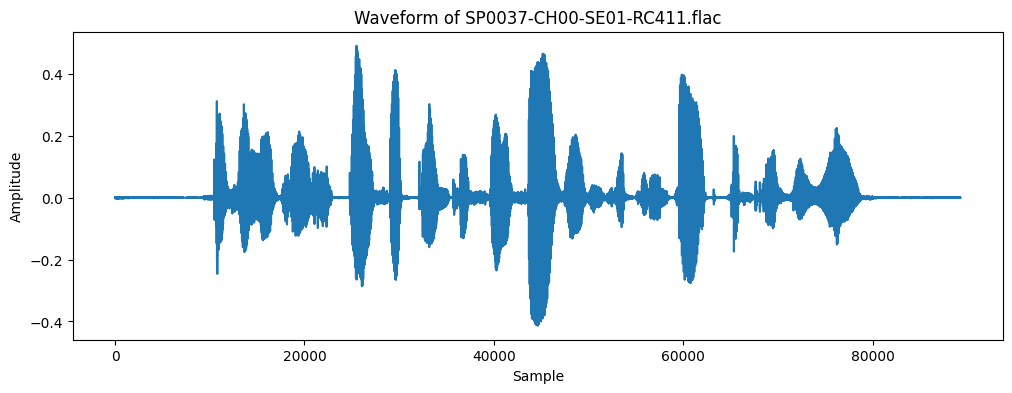

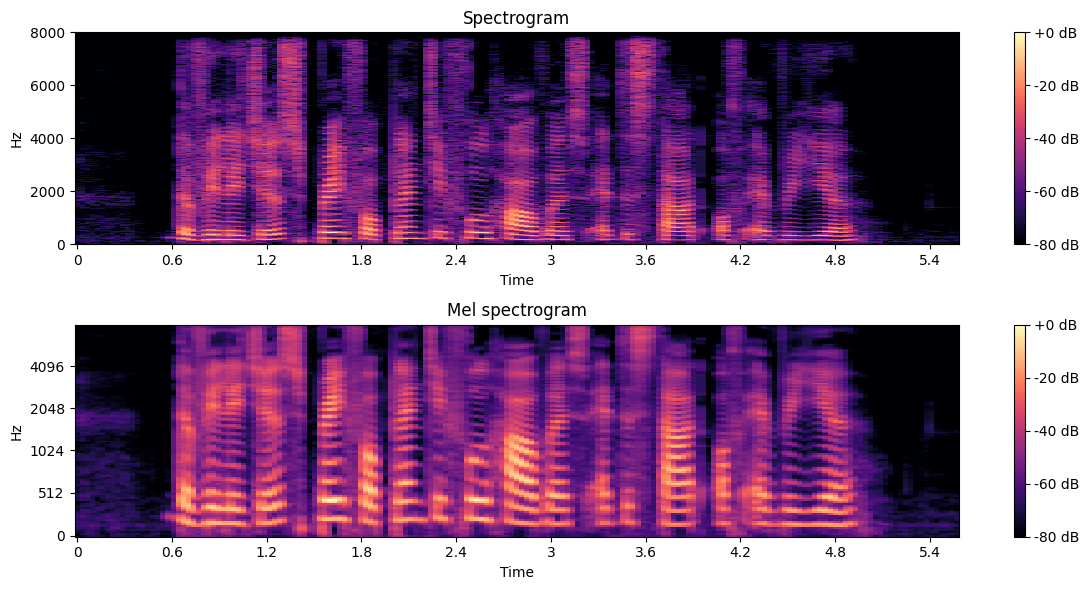

100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Audio statistics:
- Average duration: 6.73 seconds
- Min duration: 5.44 seconds
- Max duration: 8.98 seconds
- Sample rates: {16000}


In [6]:
# After downloading the dataset, let's explore it
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import random
from IPython.display import display, Audio
from tqdm import tqdm

for split_name in os.listdir(local_save_dir):
    # Skip non-directory items
    split_path = os.path.join(local_save_dir, split_name)
    if not os.path.isdir(split_path):
        continue
    
    print(f"\nExploring split: {split_name}")
    
    # Load the dataframe we saved earlier
    df_path = os.path.join(local_save_dir, f"{split_name}_data.csv")
    if os.path.exists(df_path):
        df = pd.read_csv(df_path)
        
        # Basic dataset statistics
        print(f"Number of samples: {len(df)}")
        print("\nDataframe columns:")
        for col in df.columns:
            print(f"- {col}: {df[col].dtype}")
        
        # Print a few example rows
        print("\nSample data:")
        display(df.head(3))
        
        # Find categorical columns to analyze
        categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 20]
        
        # Analyze distributions of categorical variables
        for col in categorical_cols:
            if len(df[col].unique()) > 1:  # Only plot if there's variation
                plt.figure(figsize=(10, 6))
                sns.countplot(y=col, data=df, order=df[col].value_counts().index)
                plt.title(f'Distribution of {col}')
                plt.tight_layout()
                plt.show()
        
        # Analyze audio properties
        print("\nAnalyzing audio files...")
        audio_lengths = []
        sample_rates = []
        
        # Process a few audio files to get statistics
        audio_files = [f for f in os.listdir(split_path) if f.endswith('.flac')]
        for audio_file in tqdm(audio_files[:5]):  # Limit to 5 files for quick analysis
            file_path = os.path.join(split_path, audio_file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                audio_lengths.append(duration)
                sample_rates.append(sr)
                
                # Plot waveform for the first file
                if len(audio_lengths) == 1:
                    plt.figure(figsize=(12, 4))
                    plt.plot(y)
                    plt.title(f'Waveform of {audio_file}')
                    plt.xlabel('Sample')
                    plt.ylabel('Amplitude')
                    plt.show()
                    
                    # Plot spectrogram
                    plt.figure(figsize=(12, 6))
                    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                    plt.subplot(2, 1, 1)
                    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
                    plt.colorbar(format='%+2.0f dB')
                    plt.title('Spectrogram')
                    
                    # Plot mel spectrogram
                    plt.subplot(2, 1, 2)
                    M = librosa.feature.melspectrogram(y=y, sr=sr)
                    M_db = librosa.power_to_db(M, ref=np.max)
                    librosa.display.specshow(M_db, sr=sr, x_axis='time', y_axis='mel')
                    plt.colorbar(format='%+2.0f dB')
                    plt.title('Mel spectrogram')
                    plt.tight_layout()
                    plt.show()
                    
            except Exception as e:
                print(f"Error processing {audio_file}: {e}")
        
        # Audio statistics
        if audio_lengths:
            print(f"\nAudio statistics:")
            print(f"- Average duration: {np.mean(audio_lengths):.2f} seconds")
            print(f"- Min duration: {np.min(audio_lengths):.2f} seconds")
            print(f"- Max duration: {np.max(audio_lengths):.2f} seconds")
            print(f"- Sample rates: {set(sample_rates)}")
        
        # If text transcriptions are available, analyze them
        if 'text' in df.columns:
            print("\nText statistics:")
            df['text_length'] = df['text'].astype(str).apply(len)
            df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
            
            print(f"- Average text length: {df['text_length'].mean():.2f} characters")
            print(f"- Average word count: {df['word_count'].mean():.2f} words")
            
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            sns.histplot(df['text_length'], kde=True)
            plt.title('Distribution of Text Lengths')
            plt.xlabel('Number of Characters')
            
            plt.subplot(1, 2, 2)
            sns.histplot(df['word_count'], kde=True)
            plt.title('Distribution of Word Counts')
            plt.xlabel('Number of Words')
            plt.tight_layout()
            plt.show()
            
            # Most common words (if text is available)
            all_words = ' '.join(df['text'].astype(str)).lower()
            word_counts = {}
            for word in all_words.split():
                # Remove punctuation
                word = word.strip('.,!?;:"\'()[]{}')
                if word:
                    word_counts[word] = word_counts.get(word, 0) + 1
            
            # Get top words
            top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
            
            plt.figure(figsize=(12, 6))
            sns.barplot(x=[w[1] for w in top_words], y=[w[0] for w in top_words], orient='h')
            plt.title('Most Common Words in Transcriptions')
            plt.xlabel('Count')
            plt.ylabel('Word')
            plt.tight_layout()
            plt.show()
    else:
        print(f"No CSV data found for {split_name}")

## Process into 80% train, 10% validation, 10% test splits

In [8]:
import os
import pandas as pd
import json
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
raw_dir = "../raw"
processed_dir = "../raw_splits"  
original_train_dir = os.path.join(raw_dir, "train")
original_train_excel = os.path.join(raw_dir, "train_data.xlsx")
original_train_json = os.path.join(raw_dir, "train_data.json")

# Create new processed directory
os.makedirs(processed_dir, exist_ok=True)

# Create new directories for the split inside processed_dir
split_train_dir = os.path.join(processed_dir, "train")
val_dir = os.path.join(processed_dir, "validation")
test_dir = os.path.join(processed_dir, "test")

# Create directories if they don't exist
for directory in [split_train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Load original training data
train_df = pd.read_excel(original_train_excel)

# Load the JSON data
with open(original_train_json, 'r') as f:
    train_json = json.load(f)

# Make sure the DataFrame and JSON have the same number of records
assert len(train_df) == len(train_json), "Excel and JSON files have different numbers of records"

# Split the data: 80% train, 10% validation, 10% test
train_indices, temp_indices = train_test_split(range(len(train_df)), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Function to create the split datasets
def create_split(indices, df, json_data, target_dir, split_name):
    # Create subdirectory
    os.makedirs(target_dir, exist_ok=True)
    
    # Filter data
    split_df = df.iloc[indices].reset_index(drop=True)
    split_json = [json_data[i] for i in indices]
    
    # Copy audio files to the new directory
    for i, row in split_df.iterrows():
        audio_path = row['flac']
        if isinstance(audio_path, str) and os.path.exists(audio_path):
            filename = os.path.basename(audio_path)
            new_path = os.path.join(target_dir, filename)
            shutil.copy(audio_path, new_path)
            
            # Update path in the DataFrame and JSON to reflect the new location
            split_df.at[i, 'flac'] = new_path
            split_json[i]['flac'] = new_path
    
    # Save as Excel in the splits directory
    excel_path = os.path.join(processed_dir, f"{split_name}_data.xlsx")
    split_df.to_excel(excel_path, index=False)
    
    # Save as CSV in the splits directory
    csv_path = os.path.join(processed_dir, f"{split_name}_data.csv")
    split_df.to_csv(csv_path, index=False)
    
    # Save as JSON in the splits directory
    json_path = os.path.join(processed_dir, f"{split_name}_data.json")
    with open(json_path, 'w') as f:
        json.dump(split_json, f, indent=2)
    
    print(f"Created {split_name} set with {len(indices)} examples")
    print(f"Output files: {excel_path}, {csv_path}, and {json_path}")
    
    return split_df, split_json

# Create the splits
train_split_df, train_split_json = create_split(train_indices, train_df, train_json, split_train_dir, "train")
val_split_df, val_split_json = create_split(val_indices, train_df, train_json, val_dir, "validation")
test_split_df, test_split_json = create_split(test_indices, train_df, train_json, test_dir, "test")

print(f"\nSplit complete:")
print(f"Original train set: {len(train_df)} examples")
print(f"New training set: {len(train_split_df)} examples ({len(train_split_df)/len(train_df)*100:.1f}%)")
print(f"Validation set: {len(val_split_df)} examples ({len(val_split_df)/len(train_df)*100:.1f}%)")
print(f"Test set: {len(test_split_df)} examples ({len(test_split_df)/len(train_df)*100:.1f}%)")
print(f"\nAll splits are saved in: {processed_dir}")

Created train set with 80 examples
Output files: ../raw_splits\train_data.xlsx, ../raw_splits\train_data.csv, and ../raw_splits\train_data.json
Created validation set with 10 examples
Output files: ../raw_splits\validation_data.xlsx, ../raw_splits\validation_data.csv, and ../raw_splits\validation_data.json
Created test set with 10 examples
Output files: ../raw_splits\test_data.xlsx, ../raw_splits\test_data.csv, and ../raw_splits\test_data.json

Split complete:
Original train set: 100 examples
New training set: 80 examples (80.0%)
Validation set: 10 examples (10.0%)
Test set: 10 examples (10.0%)

All splits are saved in: ../raw_splits
